In [1]:
import numpy as np
from scipy.optimize import minimize, Bounds, NonlinearConstraint

N, dt = 300, 60.0
V0, T0, V_ref = 40.0, 20.0, 30.0
Tb, a, beta = 100.0, 2.0, 0.1/3600.0
rho_mos, cp_mos, C_rec = 1.0, 4180.0, 6e4
rho_w, h_fg, eta = 0.958, 2.257e6, 0.85
P_max, T_min, T_max = 1e4, 20.0, 102.0
w1, w2 = 1.0, 0.0

def sigma(T): return 1.0/(1.0+np.exp(-a*(T-Tb)))

def unpack(x):
    P = x[:N]
    T = np.empty(N+1); T[0]=T0; T[1:] = x[N:N+N]
    V = np.empty(N+1); V[0]=V0; V[1:] = x[N+N:]
    return P, T, V

def objective(x):
    P, T, V = unpack(x)
    return w1*(V[-1]-V_ref)**2 + w2*np.sum(P)*dt

# Equality constraints stacked for all k
def volume_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N)
    for k in range(N):
        res[k] = V[k+1] - V[k]*np.exp(-beta*sigma(T[k])*dt)
    return res

def energy_residual(x):
    P, T, V = unpack(x)
    res = np.empty(N)
    for k in range(N):
        Vbar = V[k]  # or 0.5*(V[k]+V[k+1])
        sensible = (rho_mos*cp_mos*Vbar + C_rec)*(T[k+1]-T[k])
        latent   = rho_w*h_fg*(V[k]-V[k+1])
        res[k]   = eta*P[k]*dt - (sensible + latent)
    return res

cons = [
    NonlinearConstraint(volume_residual, 0.0, 0.0),
    NonlinearConstraint(energy_residual, 0.0, 0.0),
    # Temperature bounds at all nodes:
    NonlinearConstraint(lambda x: unpack(x)[1],
                        lb=T_min*np.ones(N+1),
                        ub=T_max*np.ones(N+1)),
    # Volume nonnegativity:
    NonlinearConstraint(lambda x: unpack(x)[2],
                        lb=1e-6*np.ones(N+1), ub=np.inf*np.ones(N+1)),
]


# Bounds for decisions: [P_0..P_{N-1}, T_1..T_N, V_1..V_N]
lb = np.concatenate([np.zeros(N),      T_min*np.ones(N),  1e-6*np.ones(N)])
ub = np.concatenate([P_max*np.ones(N), T_max*np.ones(N),  np.inf*np.ones(N)])
bounds = Bounds(lb, ub)

# Feasible initial guess: forward simulate with constant P
P0 = np.full(N, 0.5*P_max)
# simple forward pass to build consistent T,V
Tg = np.empty(N+1); Vg = np.empty(N+1); Tg[0]=T0; Vg[0]=V0
for k in range(N):
    Vg[k+1] = Vg[k]*np.exp(-beta*sigma(Tg[k])*dt)
    Ceff = rho_mos*cp_mos*Vg[k] + C_rec
    Tg[k+1] = Tg[k] + (eta*P0[k]*dt - rho_w*h_fg*(Vg[k]-Vg[k+1]))/Ceff

x0 = np.concatenate([P0, Tg[1:], Vg[1:]])

res = minimize(objective, x0, method='trust-constr',
               bounds=bounds, constraints=cons,
               options=dict(verbose=3, maxiter=100))

print("Status:", res.message)
P_opt, T_opt, V_opt = unpack(res.x)
print(f"V_N={V_opt[-1]:.2f} L, T_max={T_opt.max():.2f} °C, P̄={P_opt.mean():.0f} W")

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |  901  |   0   | +7.0031e+00 | 1.00e+00 | 1.00e-02 | 1.55e+02 | 1.00e+00 |  1.00e-01   |   0   |


c:\Python312\Lib\site-packages\scipy\optimize\_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


|   2   | 1802  |   1   | +7.0031e+00 | 5.60e+00 | 1.00e-02 | 1.55e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   3   | 2703  |   2   | +7.0031e+00 | 3.14e+01 | 1.00e-02 | 9.72e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   4   | 3604  |   3   | +7.0031e+00 | 4.00e+01 | 1.34e-02 | 3.46e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   5   | 4505  |   4   | +7.0031e+00 | 4.00e+01 | 1.73e-02 | 1.87e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   6   | 5406  |   6   | +7.0031e+00 | 4.00e+01 | 2.15e-02 | 1.03e+03 | 1.00e+00 |  1.00e-01   |   4   |
|   7   | 6307  |   9   | +7.0031e+00 | 4.00e+01 | 2.56e-02 | 8.50e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   8   | 7208  |  12   | +7.0031e+00 | 4.00e+01 | 2.86e-02 | 5.66e+02 | 1.00e+00 |  1.00e-01   |   4   |
|   9   | 8109  |  15   | +7.0031e+00 | 4.00e+01 | 2.77e-02 | 4.99e+02 | 1.00e+00 |  1.00e-01   |   4   |
|  10   | 9010  |  19   | +7.0030e+00 | 4.00e+01 | 3.06e-02 | 3.68e+02 | 1.00e+00 |  1.00e-01   |   4   |
|  11   | 9911  |  21   | +7.0026e+00 | 4.00e+

c:\Python312\Lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:217: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


|  73   | 64872 |  330  | +1.6630e+00 | 1.49e+02 | 8.71e-05 | 2.71e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  74   | 66674 |  346  | +1.6630e+00 | 1.49e+01 | 8.71e-05 | 2.71e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  75   | 68476 |  359  | +1.6482e+00 | 1.05e+02 | 8.69e-05 | 3.68e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  76   | 70278 |  373  | +1.6482e+00 | 1.05e+01 | 8.69e-05 | 3.68e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  77   | 72080 |  383  | +1.6379e+00 | 7.32e+01 | 8.67e-05 | 4.88e-05 | 5.78e+00 |  3.20e-05   |   2   |
|  78   | 73882 |  404  | +1.6379e+00 | 7.32e+00 | 8.67e-05 | 4.88e-05 | 5.78e+00 |  3.20e-05   |   2   |
|  79   | 75684 |  415  | +1.6306e+00 | 7.32e+00 | 8.67e-05 | 3.19e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  80   | 77486 |  422  | +1.6232e+00 | 1.46e+01 | 8.66e-05 | 4.71e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  81   | 79288 |  430  | +1.6232e+00 | 1.46e+00 | 8.66e-05 | 4.71e-04 | 5.78e+00 |  3.20e-05   |   2   |
|  82   | 81090 |  438  | +1.6218e+00 | 1.02e+

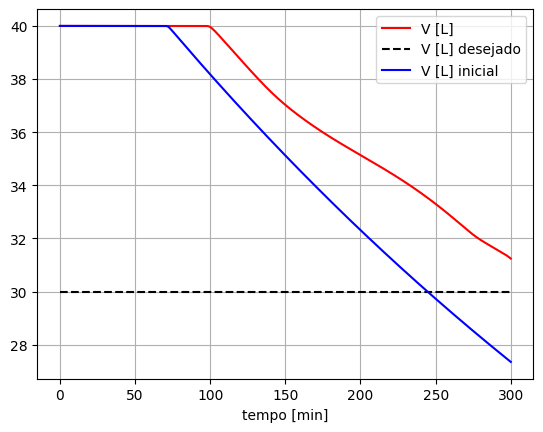

In [2]:
# %matplotlib inline
# Caso queira ver as três séries:
import matplotlib.pyplot as plt
t = np.arange(N+1)*dt/60.0   # minutos
plt.plot(t, V_opt, color='red', label='V [L]')
plt.plot(t, np.full(V_opt.shape, V_ref), '--',color='black', label='V [L] desejado')
plt.plot(t, Vg, color='blue', label='V [L] inicial')
# plt.plot(t, T_opt, label='T [°C]')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()

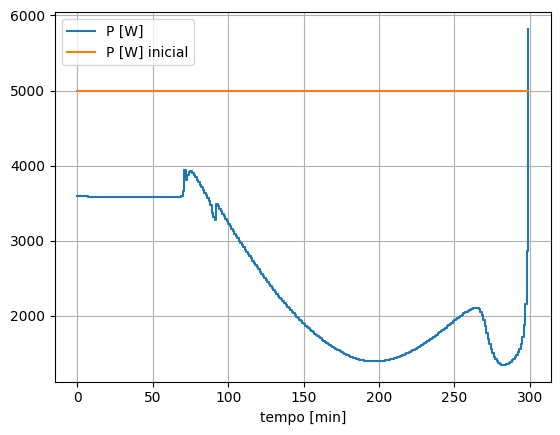

In [3]:
plt.step(t[:-1], P_opt, where='post', label='P [W]')
plt.step(t[:-1], P0, where='post', label='P [W] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()


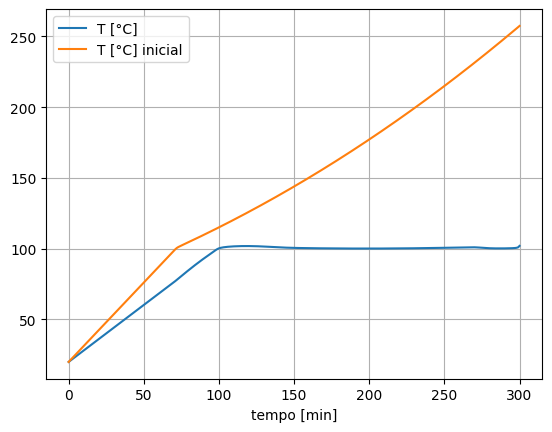

In [4]:
plt.plot(t, T_opt, label='T [°C]')
plt.plot(t, Tg, label='T [°C] inicial')
plt.legend(); plt.xlabel('tempo [min]'); plt.grid(True); plt.show()